# LAMMPS workshop - lammps demo - basic_exercise

This is a quick wrapper around the basic exercise example that can be used in colab and uses atomman for setup and processing

## 1. Python setup

This cell sets up Python for running the calculation

### 1.1. Local run

If you are running this Notebook locally, you will need LAMMPS installed, and have atomman and py3Dmol installed to your Python environment.

### 1.2. colab

If you are running this Notebook in colab, the first cell will download a LAMMPS executable and install the necessary Python packages.  Once done, go up to the colab menu to restart runtime. After restarting, this cell will properly import the now installed packages

In [ ]:
# Standard Python packages
import os
from pathlib import Path

# Test if this is a colab environment
iscolab = 'COLAB_RELEASE_TAG' in os.environ

# Install LAMMPS and atomman in colab if needed
if iscolab and not Path('lmp').exists():
    
    if not Path('run').exists():
        Path('run').mkdir()
    
    print('Installing LAMMPS - please wait...')
    !wget https://github.com/lmhale99/atomman-demo/raw/main/lmp.gz
    !gunzip lmp.gz
    !chmod 755 lmp
    
    print('Installing atomman')
    !pip install atomman py3Dmol

    print('!!!!! RESTART KERNEL/RUNTIME BEFORE CONTINUING!!!!!')
    
# Import installed packages
else:
    from IPython.display import Image, Video
    import atomman as am
    import atomman.unitconvert as uc
    print(f'atomman version {am.__version__} loaded')
    import matplotlib.pyplot as plt

## 2. Specify LAMMPS executable

If you are running locally, you may need to change the setting to point to your LAMMPS executable.

In [2]:
if iscolab:
    # LAMMPS command for colab
    lammps_command = '/content/lmp'
else:
    # LAMMPS command for your system!
    lammps_command = 'lmp'
    
# Test that the lammps executable works and print LAMMPS version
print('Using LAMMPS version', am.lammps.checkversion(lammps_command)['version'])

## 3. Define LAMMPS script

This is the in.friction script with variables added for Tasks 2 and 3
- raduis1 is the radius for the lo-sphere
- raduis2 is the radius for the hi-sphere
- runsteps is how many steps to run

In [3]:
friction_script = """
# 2d friction due to surface asperities

# ---------------
# settings
# ---------------

dimension	2
boundary	p s p

atom_style	atomic
neighbor	0.3 bin
neigh_modify	delay 5

# ---------------
# create simulation box
# ---------------

lattice		hex 0.9
region		box block 0 50 0 22 -0.25 0.25
create_box	4 box

mass		* 1.0

# ---------------
# create upper and lower surfaces of atoms
# ---------------

region          lo-fixed block INF INF INF 1.1 INF INF
region          lo-slab block INF INF INF 7 INF INF
region          above-lo block INF INF INF 7 INF INF side out

region          hi-fixed block INF INF 20.9 INF INF INF
region          hi-slab block INF INF 15 INF INF INF
region          below-hi block INF INF 15 INF INF INF side out

create_atoms	1 region lo-slab
create_atoms	1 region hi-slab

# ---------------
# create half-sphere asperities on each surface
# ---------------

# TASK 2: last argument of next 2 lines is the radius
#         of the lower and upper asperities, 
#         change either or both of the values
#         NOTE: making both 10 is too large (they overlap)

region		lo-asperity sphere 32 7 0 <radius1>
region		hi-asperity sphere 18 15 0 <radius2>
region		lo-bump intersect 2 lo-asperity above-lo
region		hi-bump intersect 2 hi-asperity below-hi

# TASK 4: un-comment the next 2 lines
#         you MUST also comment out the previous 4 lines

#region		lo-bump block 28 36 7.8 12 INF INF
#region		hi-bump block 14 22 10 14.8 INF INF

create_atoms	2 region lo-bump
create_atoms	3 region hi-bump

# ---------------
# LJ potential
# ---------------

pair_style	lj/cut 2.5
pair_coeff	* * 1.0 1.0 2.5

# ---------------
# define groups and change atom types
# ---------------

group	        lo region lo-slab
group		lo type 2
group		hi region hi-slab
group		hi type 3
group		lo-fixed region lo-fixed
group		hi-fixed region hi-fixed
group		boundary union lo-fixed hi-fixed
group		mobile subtract all boundary

set		group lo-fixed type 4
set		group hi-fixed type 4

# ---------------
# initial velocities
# ---------------

compute         ydim mobile temp/partial 0 1 0
velocity	mobile create 0.1 482748 temp ydim
velocity	hi set 1.0 0.0 0.0 sum yes

# ---------------
# fixes to drag one surf across the other
# ---------------

fix		1 all nve
fix		2 boundary setforce 0.0 0.0 0.0
fix		3 mobile temp/rescale 200 0.1 0.1 0.02 1.0
fix_modify	3 temp ydim

fix             4 all enforce2d

# ---------------
# output
# ---------------

thermo		1000
thermo_modify	temp ydim

dump		1 all atom 500 dump.friction

dump		2 all image 500 image.*.jpg type type &
		zoom 1.6 adiam 1.5
dump_modify	2 pad 5

# command for Mac and Linux
dump		3 all movie 500 movie.mpg type type &
		zoom 1.6 adiam 1.5

# command for Windows
#dump            3 all movie 500 movie.avi type type &
#                zoom 1.6 adiam 1.5

dump_modify	3 pad 5

# ---------------
# run
# ---------------

# TASK 3: double the run length (number of steps)

timestep	0.0025
run		<runsteps>
"""

The variables in the above script can be filled in using a Python dict as shown below to create the full filled-in script

In [ ]:
lammps_variables = {}
lammps_variables['radius1'] = 8
lammps_variables['radius2'] = 8
lammps_variables['runsteps'] = 20000

script = am.tools.filltemplate(friction_script, lammps_variables, '<', '>')

## 4. Run LAMMPS

In [4]:
# Run LAMMPS
log = am.lammps.run(lammps_command, script=script)

# Get thermo data for first (and only) simulation
thermo = log.simulations[0].thermo

# Plot something
plt.plot(thermo.Step, thermo.Press)

In [19]:
final = am.load('atom_dump', 'dump.friction')
am.plot.py3Dmol.view_3d(final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 5. Look at outputs directly using IPython display objects

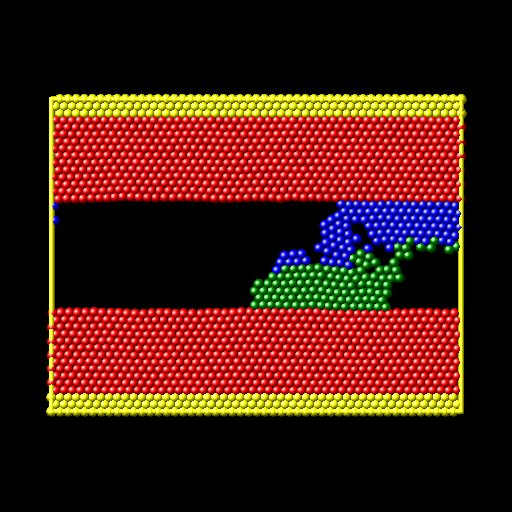

In [15]:
Image('image.10000.jpg')

In [16]:
Video('movie.mpg')

## 6. File cleanup

This will delete all files generated by LAMMPS

In [22]:
for fglob in ['image.*.jpg', 'dump.friction', 'log.lammps', 'movie.mpg']:
    for fpath in Path.cwd().glob(fglob):
        fpath.unlink()